# Machine Learning Foundation

## Section 2, Part d:  Regularization and Gradient Descent

## Introduction

We will begin with a short tutorial on regression, polynomial features, and regularization based on a very simple, sparse data set that contains a column of `x` data and associated `y` noisy data. The data file is called `X_Y_Sinusoid_Data.csv`. 

In [1]:
import os

## Question 1

* Import the data. 

* Also generate approximately 100 equally spaced x data points over the range of 0 to 1. Using these points, calculate the y-data which represents the "ground truth" (the real function) from the equation: $y = sin(2\pi x)$

* Plot the sparse data (`x` vs `y`) and the calculated ("real") data.


In [3]:
import pandas as pd
import numpy as np
 
data = pd.read_csv('Sinusoid_Data.csv')

X_real = np.linspace(0, 1.0, 100)
Y_real = np.sin(2 * np.pi * X_real)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

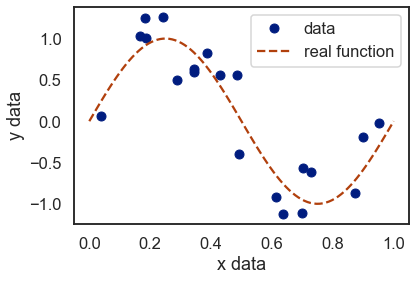

In [5]:
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

# Plot of the noisy (sparse)
ax = data.set_index('x')['y'].plot(ls='', marker='o', label='data')
ax.plot(X_real, Y_real, ls='--', marker='', label='real function')

ax.legend()
ax.set(xlabel='x data', ylabel='y data');


## Question 2


* Using the `PolynomialFeatures` class from Scikit-learn's preprocessing library, create 20th order polynomial features.
* Fit this data using linear regression. 
* Plot the resulting predicted value compared to the calculated data.

Note that `PolynomialFeatures` requires either a dataframe (with one column, not a Series) or a 2D array of dimension (`X`, 1), where `X` is the length.

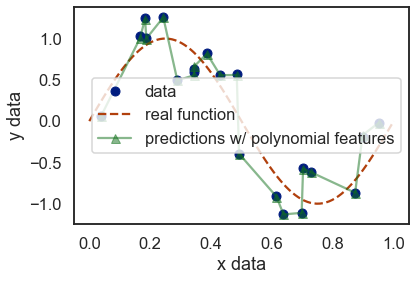

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Setup the polynomial features
degree = 20
pf = PolynomialFeatures(degree)
lr = LinearRegression()

# Extract the X- and Y- data from the dataframe 
X_data = data[['x']]
Y_data = data['y']

# Create the features and fit the model
X_poly = pf.fit_transform(X_data)
lr = lr.fit(X_poly, Y_data)
Y_pred = lr.predict(X_poly)

# Plot the result
plt.plot(X_data, Y_data, marker='o', ls='', label='data', alpha=1)
plt.plot(X_real, Y_real, ls='--', label='real function')
plt.plot(X_data, Y_pred, marker='^', alpha=.5, label='predictions w/ polynomial features')
plt.legend()
ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');


## Question 3

* Perform the regression on using the data with polynomial features using ridge regression ($\alpha$=0.001) and lasso regression ($\alpha$=0.0001). 
* Plot the results, as was done in Question 1. 
* Also plot the magnitude of the coefficients obtained from these regressions, and compare them to those obtained from linear regression in the previous question. The linear regression coefficients will likely need a separate plot (or their own y-axis) due to their large magnitude. 

What does the comparatively large magnitude of the data tell you about the role of regularization?

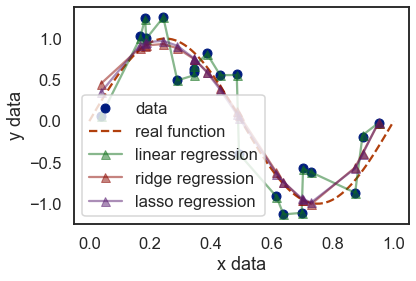

In [7]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

from sklearn.linear_model import Ridge, Lasso

# The ridge regression model
rr = Ridge(alpha=0.001)
rr = rr.fit(X_poly, Y_data)
Y_pred_rr = rr.predict(X_poly)

# The lasso regression model
lassor = Lasso(alpha=0.0001)
lassor = lassor.fit(X_poly, Y_data)
Y_pred_lr = lassor.predict(X_poly)

# The plot of the predicted values
plt.plot(X_data, Y_data, marker='o', ls='', label='data')
plt.plot(X_real, Y_real, ls='--', label='real function')
plt.plot(X_data, Y_pred, label='linear regression', marker='^', alpha=.5)
plt.plot(X_data, Y_pred_rr, label='ridge regression', marker='^', alpha=.5)
plt.plot(X_data, Y_pred_lr, label='lasso regression', marker='^', alpha=.5)

plt.legend()

ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');

In [8]:
# let's look at the absolute value of coefficients for each model

coefficients = pd.DataFrame()
coefficients['linear regression'] = lr.coef_.ravel()
coefficients['ridge regression'] = rr.coef_.ravel()
coefficients['lasso regression'] = lassor.coef_.ravel()
coefficients = coefficients.applymap(abs)

coefficients.describe()  # Huge difference in scale between non-regularized vs regularized regression

,linear regression,ridge regression,lasso regression
count,2.100000e+01,21.000000,21.000000
mean,5.761504e+13,2.169397,2.167284
std,6.017426e+13,2.900278,4.706731
min,1.610728e+07,0.000000,0.000000
25%,3.402091e+12,0.467578,0.000000
50%,3.614874e+13,1.017272,0.252181
75%,1.068696e+14,2.883507,1.641353
max,1.652485e+14,12.429635,20.176708


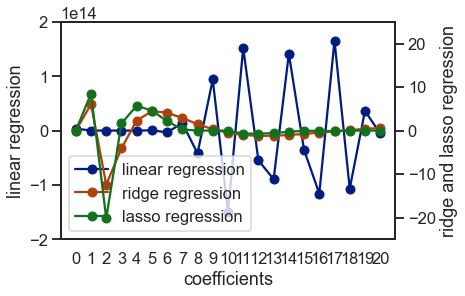

In [9]:
colors = sns.color_palette()

# Setup the dual y-axes
ax1 = plt.axes()
ax2 = ax1.twinx()

# Plot the linear regression data
ax1.plot(lr.coef_.ravel(), 
         color=colors[0], marker='o', label='linear regression')

# Plot the regularization data sets
ax2.plot(rr.coef_.ravel(), 
         color=colors[1], marker='o', label='ridge regression')

ax2.plot(lassor.coef_.ravel(), 
         color=colors[2], marker='o', label='lasso regression')

# Customize axes scales
ax1.set_ylim(-2e14, 2e14)
ax2.set_ylim(-25, 25)

# Combine the legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2)

ax1.set(xlabel='coefficients',ylabel='linear regression')
ax2.set(ylabel='ridge and lasso regression')

ax1.set_xticks(range(len(lr.coef_)));

## Question 4

For the remaining questions, we will be working with the [data set](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) from last lesson, which is based on housing prices in Ames, Iowa. There are an extensive number of features--see the exercises from week three for a discussion of these features.

To begin:

* Import the data with Pandas, remove any null values, and one hot encode categoricals. Either Scikit-learn's feature encoders or Pandas `get_dummies` method can be used.
* Split the data into train and test sets. 
* Log transform skewed features. 
* Scaling can be attempted, although it can be interesting to see how well regularization works without scaling features.

In [13]:
data = pd.read_csv('Ames_Housing_Sales.csv', sep=',')

Create a list of categorial data and one-hot encode. Pandas one-hot encoder (`get_dummies`) works well with data that is defined as a categorical.

In [14]:
# Get a Pd.Series consisting of all the string categoricals
one_hot_encode_cols = data.dtypes[data.dtypes == np.object]  # filtering by string categoricals
one_hot_encode_cols = one_hot_encode_cols.index.tolist()  # list of categorical fields

# Here we see another way of one-hot-encoding:
# Encode these columns as categoricals so one hot encoding works on split data (if desired)
for col in one_hot_encode_cols:
    data[col] = pd.Categorical(data[col])

# Do the one hot encoding
data = pd.get_dummies(data, columns=one_hot_encode_cols)

Next, split the data in train and test data sets.

In [15]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.3, random_state=42)

There are a number of columns that have skewed features--a log transformation can be applied to them. Note that this includes the `SalePrice`, our predictor. However, let's keep that one as is.

In [16]:
# Create a list of float colums to check for skewing
mask = data.dtypes == np.float
float_cols = data.columns[mask]

In [17]:
skew_limit = 0.75
skew_vals = train[float_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols

,Skew
MiscVal,26.915364
PoolArea,15.777668
LotArea,11.501694
LowQualFinSF,11.210638
3SsnPorch,10.150612
ScreenPorch,4.599803
BsmtFinSF2,4.466378
EnclosedPorch,3.218303
LotFrontage,3.138032
MasVnrArea,2.492814


Transform all the columns where the skew is greater than 0.75, excluding "SalePrice".

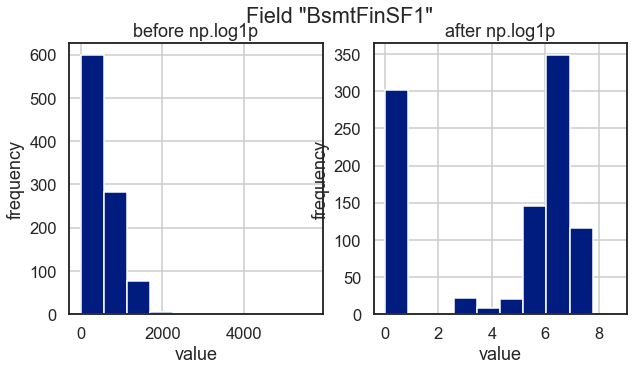

In [18]:
# OPTIONAL: Let's look at what happens to one of these features, when we apply np.log1p visually.

field = "BsmtFinSF1"
fig, (ax_before, ax_after) = plt.subplots(1, 2, figsize=(10, 5))
train[field].hist(ax=ax_before)
train[field].apply(np.log1p).hist(ax=ax_after)
ax_before.set(title='before np.log1p', ylabel='frequency', xlabel='value')
ax_after.set(title='after np.log1p', ylabel='frequency', xlabel='value')
fig.suptitle('Field "{}"'.format(field));
# a little bit better

In [19]:
# Mute the setting wtih a copy warnings
pd.options.mode.chained_assignment = None

for col in skew_cols.index.tolist():
    if col == "SalePrice":
        continue
    train[col] = np.log1p(train[col])
    test[col]  = test[col].apply(np.log1p)  # same thing

Separate features from predictor.

In [20]:
feature_cols = [x for x in train.columns if x != 'SalePrice']
X_train = train[feature_cols]
y_train = train['SalePrice']

X_test  = test[feature_cols]
y_test  = test['SalePrice']

## Question 5

* Write a function **`rmse`** that takes in truth and prediction values and returns the root-mean-squared error. Use sklearn's `mean_squared_error`.  


In [21]:
from sklearn.metrics import mean_squared_error


def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

* Fit a basic linear regression model
* print the root-mean-squared error for this model
* plot the predicted vs actual sale price based on the model.  

In [22]:
from sklearn.linear_model import LinearRegression

linearRegression = LinearRegression().fit(X_train, y_train)

linearRegression_rmse = rmse(y_test, linearRegression.predict(X_test))

print(linearRegression_rmse)

306369.68342322065


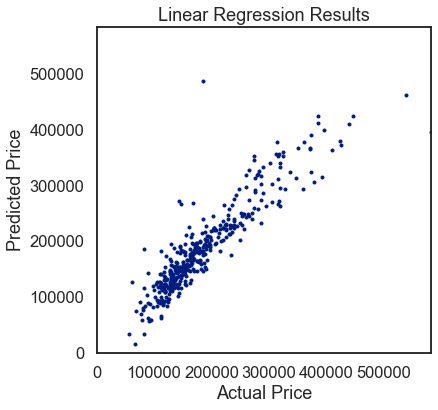

In [23]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

ax.plot(y_test, linearRegression.predict(X_test), 
         marker='o', ls='', ms=3.0)

lim = (0, y_test.max())

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       xlim=lim,
       ylim=lim,
       title='Linear Regression Results');

## Question 6

Ridge regression uses L2 normalization to reduce the magnitude of the coefficients. This can be helpful in situations where there is high variance. The regularization functions in Scikit-learn each contain versions that have cross-validation built in.

* Fit a regular (non-cross validated) Ridge model to a range of $\alpha$ values and plot the RMSE using the cross validated error function you created above.
* Use $$[0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]$$ as the range of alphas.
* Then repeat the fitting of the Ridge models using the range of $\alpha$ values from the prior section. Compare the results.

Now for the `RidgeCV` method. It's not possible to get the alpha values for the models that weren't selected, unfortunately. The resulting error values and $\alpha$ values are very similar to those obtained above.

In [24]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]

ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test))

print(ridgeCV.alpha_, ridgeCV_rmse)

15.0 32169.176205672433


## Question 7


Much like the `RidgeCV` function, there is also a `LassoCV` function that uses an L1 regularization function and cross-validation. L1 regularization will selectively shrink some coefficients, effectively performing feature elimination.

The `LassoCV` function does not allow the scoring function to be set. However, the custom error function (`rmse`) created above can be used to evaluate the error on the final model.

Similarly, there is also an elastic net function with cross validation, `ElasticNetCV`, which is a combination of L2 and L1 regularization.

* Fit a Lasso model using cross validation and determine the optimum value for $\alpha$ and the RMSE using the function created above. Note that the magnitude of $\alpha$ may be different from the Ridge model.
* Repeat this with the Elastic net model.
* Compare the results via table and/or plot.

Use the following alphas:  
`[1e-5, 5e-5, 0.0001, 0.0005]`

In [ ]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test))

print(lassoCV.alpha_, lassoCV_rmse)  # Lasso is slower

We can determine how many of these features remain non-zero.

In [ ]:
print('Of {} coefficients, {} are non-zero with Lasso.'.format(len(lassoCV.coef_), 
                                                               len(lassoCV.coef_.nonzero()[0])))

Now try the elastic net, with the same alphas as in Lasso, and l1_ratios between 0.1 and 0.9

In [ ]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

Comparing the RMSE calculation from all models is easiest in a table.

In [ ]:
rmse_vals = [linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

We can also make a plot of actual vs predicted housing prices as before.

In [ ]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'ElasticNet']

models = [ridgeCV, lassoCV, elasticNetCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=3.0, label=lab)


leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');

## Question 8

Let's explore Stochastic gradient descent in this exercise.  
Recall that Linear models in general are sensitive to scaling.
However, SGD is *very* sensitive to scaling.  
Moreover, a high value of learning rate can cause the algorithm to diverge, whereas a too low value may take too long to converge.

* Fit a stochastic gradient descent model without a regularization penalty (the relevant parameter is `penalty`).
* Now fit stochastic gradient descent models with each of the three penalties (L2, L1, Elastic Net) using the parameter values determined by cross validation above. 
* Do not scale the data before fitting the model.  
* Compare the results to those obtained without using stochastic gradient descent.

In [ ]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD'] = pd.Series(new_rmses)
rmse_df

Notice how high the error values are! The algorithm is diverging. This can be due to scaling and/or learning rate being too high. Let's adjust the learning rate and see what happens.

* Pass in `eta0=1e-7` when creating the instance of `SGDClassifier`.
* Re-compute the errors for all the penalties and compare.

In [ ]:
# Import SGDRegressor and prepare the parameters

from sklearn.linear_model import SGDRegressor

model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l1',
           'alpha': ridgeCV_rmse},
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7, **parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD-learningrate'] = pd.Series(new_rmses)
rmse_df

Now let's scale our training data and try again.

* Fit a `MinMaxScaler` to `X_train` create a variable `X_train_scaled`.
* Using the scaler, transform `X_test` and create a variable `X_test_scaled`. 
* Apply the same versions of SGD to them and compare the results. Don't pass in a eta0 this time.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(**parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = rmse(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

---
### Machine Learning Foundation (C) 2020 IBM Corporation